In [2]:
# Import data
import pandas as pd


In [3]:
interaction_df = pd.read_csv('goodreads_interactions.csv')

In [4]:
interaction_df

,user_id,book_id,is_read,rating,is_reviewed
0,0,948,1,5,0
1,0,947,1,5,1
2,0,946,1,5,0
3,0,945,1,5,0
4,0,944,1,5,0
...,...,...,...,...,...
228648337,876144,24772,0,0,0
228648338,876144,23847,1,4,0
228648339,876144,23950,1,3,0
228648340,876144,374106,1,5,1


In [5]:
interaction_df.describe()


,user_id,book_id,is_read,rating,is_reviewed
count,2.286483e+08,2.286483e+08,2.286483e+08,2.286483e+08,2.286483e+08
mean,2.500636e+05,2.015756e+05,4.904090e-01,1.801340e+00,7.093491e-02
std,1.712713e+05,3.448677e+05,4.999080e-01,2.072672e+00,2.567161e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.143010e+05,1.252700e+04,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.338990e+05,5.034600e+04,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.581100e+05,2.229240e+05,1.000000e+00,4.000000e+00,0.000000e+00
max,8.761440e+05,2.360649e+06,1.000000e+00,5.000000e+00,1.000000e+00


In [6]:
interaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228648342 entries, 0 to 228648341
Data columns (total 5 columns):
 #   Column       Dtype
---  ------       -----
 0   user_id      int64
 1   book_id      int64
 2   is_read      int64
 3   rating       int64
 4   is_reviewed  int64
dtypes: int64(5)
memory usage: 8.5 GB


In [7]:
interaction_df.isnull().sum()

user_id        0
book_id        0
is_read        0
rating         0
is_reviewed    0
dtype: int64

In [8]:
# I actually care only about user_id, book_id and rating of books that were read by the user

interaction_df_clean = interaction_df[['user_id', 'book_id', 'rating']][interaction_df['is_read'] == 1]

KeyboardInterrupt: 

In [8]:
interaction_df_clean

,user_id,book_id,rating
0,0,948,5
1,0,947,5
2,0,946,5
3,0,945,5
4,0,944,5
...,...,...,...
228648336,876144,367428,3
228648338,876144,23847,4
228648339,876144,23950,3
228648340,876144,374106,5


In [9]:
# Group by user_id and count unique book_ids
books_per_user = interaction_df_clean.groupby('user_id')['book_id'].nunique()

books_per_user

user_id
0         482
1         103
2         191
3         108
4         182
         ... 
876140     14
876141     11
876142     32
876143     23
876144     41
Name: book_id, Length: 836433, dtype: int64

In [10]:
books_per_user.describe()

count    836433.000000
mean        134.058798
std         245.629388
min           1.000000
25%          23.000000
50%          59.000000
75%         149.000000
max       38895.000000
Name: book_id, dtype: float64

In [11]:
percentile = books_per_user.quantile(0.99)
percentile

np.float64(1101.0)

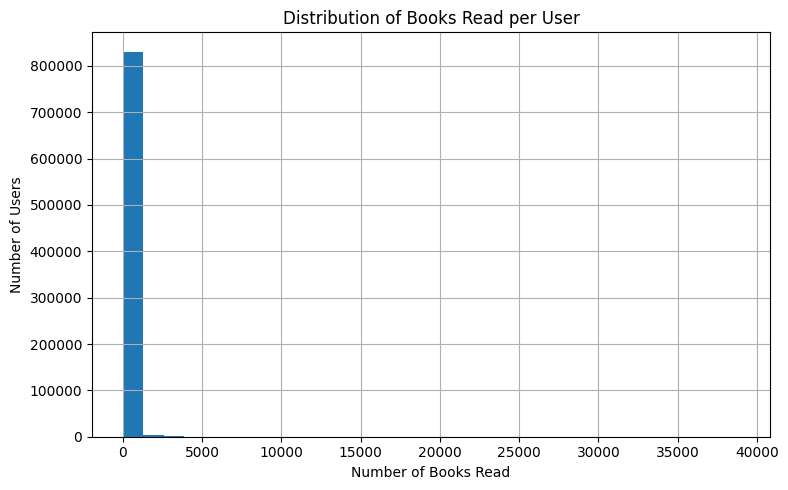

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
books_per_user.plot(kind='hist', bins=30)
plt.xlabel('Number of Books Read')
plt.ylabel('Number of Users')
plt.title('Distribution of Books Read per User')
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
#Compute the 99th percentile
threshold_99 = books_per_user.quantile(0.99)

# Step 3: Identify users at or below the threshold
valid_users = books_per_user[books_per_user <= threshold_99].index

# Step 4: Filter the original dataframe
filtered_df = interaction_df_clean[interaction_df_clean['user_id'].isin(valid_users)]
filtered_df

,user_id,book_id,rating
0,0,948,5
1,0,947,5
2,0,946,5
3,0,945,5
4,0,944,5
...,...,...,...
228648336,876144,367428,3
228648338,876144,23847,4
228648339,876144,23950,3
228648340,876144,374106,5


In [23]:
# This is not working as the resulting array is to large
# rating_matrix = filtered_df.pivot_table(
#     index = ['user_id']
#     , columns = ['book_id']
#     , values = 'rating')

# rating_matrix.head()

In [14]:
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder

# Encode user_ids and book_ids as numeric
user_encoder = LabelEncoder()
book_encoder = LabelEncoder()

filtered_df['user_idx'] = user_encoder.fit_transform(filtered_df['user_id'])
filtered_df['book_idx'] = book_encoder.fit_transform(filtered_df['book_id'])

# Create sparse matrix
sparse_matrix = csr_matrix(
    (filtered_df['rating'], (filtered_df['user_idx'], filtered_df['book_idx']))
)

print(sparse_matrix.shape)  # (num_users, num_books)

C:\Users\k-bur\AppData\Local\Temp\ipykernel_25056\2021380138.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['user_idx'] = user_encoder.fit_transform(filtered_df['user_id'])
C:\Users\k-bur\AppData\Local\Temp\ipykernel_25056\2021380138.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['book_idx'] = book_encoder.fit_transform(filtered_df['book_id'])


(828084, 2197169)


In [ ]:
# # cosine similarity
# from sklearn.metrics.pairwise import cosine_similarity

# # Compute cosine similarity between users
# user_sim_matrix = cosine_similarity(sparse_matrix)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def top_k_similar_users(sparse_matrix, k=10):
    sim_matrix = cosine_similarity(sparse_matrix, dense_output=False)
    sim_matrix = sim_matrix.tolil()  # convert to LIL for efficient row operations

    # Zero out all but top-k per row
    for i in range(sim_matrix.shape[0]):
        row = sim_matrix.data[i]
        if len(row) > k:
            top_k_idx = np.argsort(row)[-k:]
            mask = np.ones(len(row), dtype=bool)
            mask[top_k_idx] = False
            for j in reversed(np.where(mask)[0]):
                del sim_matrix.data[i][j]
                del sim_matrix.rows[i][j]

    return sim_matrix.tocsr()

user_sim_topk = top_k_similar_users(sparse_matrix, k=10)